# Hue-Encoded Shutter Method (HESM) 

Main implementation notebook of our paper "Temporal Super-Resolution Microscopy Using a
Hue-Encoded Shutter", BOE xxxx 2019

Christian Jaques, Idiap, 
Christian.jaques@idiap.ch

In [2]:
%load_ext autoreload
%autoreload 2
import os
import platform
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from utils import *
from HESM_functions import *
import tifffile as tiff

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)


# Global parameters to execute the whole notebook with right cells
directory = '../data/'
filename = directory + 'figure2_ims.npy'

### Load images and debayer them

Text(0.5,1,'RGB values over the whole set of images')

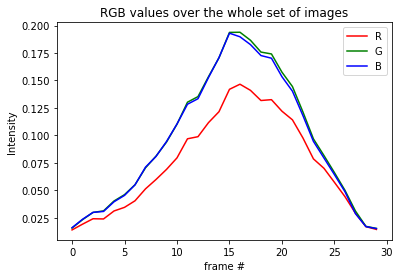

In [3]:
ims = np.load(filename) 

# debayer sequence
X, Y, N = ims.shape
ims_rgb = np.zeros((N,X,Y,3))
rgb_mean = np.zeros((N,3))
for i in range(N):
    ims_rgb[i] = demosaicing_CFA_Bayer_bilinear(ims[..., i])/ 255.
    rgb_mean[i,0] = np.mean(ims_rgb[i,:,:,0])
    rgb_mean[i,1] = np.mean(ims_rgb[i,:,:,1])
    rgb_mean[i,2] = np.mean(ims_rgb[i,:,:,2])

plt.plot(rgb_mean[:,0], 'r')
plt.plot(rgb_mean[:,1], 'g')
plt.plot(rgb_mean[:,2], 'b')
plt.legend(['R', 'G', 'B'])
plt.xlabel('frame #')
plt.ylabel('Intensity')
plt.title('RGB values over the whole set of images')

## Solve Equation (12) to reconstruct $\mathbf{x}^\star$

In [4]:
# load parameters calibrated in another notebook
gamma_params = np.load(directory+'gamma.npy')
D = np.hstack(np.load(directory+'D.npy'))
# build S and Gamma matrices
S = build_S_matrix(time_functions=[[1, 0, 0], [0, 1, 0],  [0, 0, 1]])  # this code was different for Experiment 4.4
Gamma = build_Gamma_matrix(params=gamma_params)
A = S.dot(Gamma)
print('Condition number of system matrix', np.linalg.cond(A))

ims = ims_rgb #[2:15] # you may shorten the image sequence for faster tests
x_star = apply_HESM(ims, A, D, lambd=0.001, verbose=True)

# useful for data manipulation, files saving
f = np.swapaxes(np.swapaxes(x_star,0,2),1,2)  # reorder axes

('Condition number of system matrix', 1.85267305079526)
Starting computations
('Done in ', 9.404325008392334, ' seconds')


# Select hue and apply it to super-resolved reconstruction

In [5]:
select_color_on_image = False # if false, images will be greyscale

if(select_color_on_image is True):
    image = plt.imread(directory + 'figure3_both_papers_white_light.png')
    roi_white = select_roi(image, 'Select hue area')

    xw = int(roi_white.pos()[0])
    yw = int(roi_white.pos()[1])
    ww = int(roi_white.size()[0])
    hw = int(roi_white.size()[1])
    r = float(np.mean(image[xw:xw+ww, yw:yw+hw,0]))
    g = float(np.mean(image[xw:xw+ww, yw:yw+hw,1]))
    b = float(np.mean(image[xw:xw+ww, yw:yw+hw,2]))
else:
    r = 1
    g = 1
    b = 1

N, x, y = f.shape
hesm_res = np.zeros((N, x, y,3))

hesm_res[...,0] = r*f
hesm_res[...,1] = g*f
hesm_res[...,2] = b*f
hesm_res = stretch_contrast(hesm_res, 0, 256).astype(np.uint8)
write_tiff_stack(hesm_res, "result_stack_")

# Results are saved as a tiff-stack
An easy way to open them is using [Fiji](https://fiji.sc/)